                                            DEEP LEARNING PROJECT

                                               ALEXANDER WEYHE

                                      DIEGO FRASSINELLI & ANDREA FERREIRA

                                                TASK DESCRIPTION:
The present notebook deals with Named Entity Recognition (NER). The goal is to train three different neural network models on a labeled dataset to learn recognizing named entities. To begin with, the task of NER is about identifying named entities in a text. Named entities can include: names of persons, organizations, locations, dates, and others. Once a model recognizes a named entity as such, a corresponding label is assigned to the entity, e.g. "University of Konstanz" -> ORG (organization), "Konstanz" -> LOC (location). The next cell illustrates the task of Named Entity Recognition using the spacy library.
    

In [2]:
# First we import spacy and load the displacy function.
import spacy
from spacy import displacy

# We load the specific spacy model we want to work with, here "en_core_web_sm".
nlp = spacy.load("en_core_web_sm")

# Finally, we input our example text to the spacy pipeline which outputs all recognized entites in our text.
text = "The University of Konstanz was founded in 1966 and is located in the south of Germany."
doc1 = nlp(text)
displacy.render(doc1, style="ent")

                                        LOADING AND EXPLORING THE DATASET:

The very first steps of our project will be (1) to load the dataset into our notebook and (2) explore some features of the dataset. 

The dataset we use is taken from kaggle: https://www.kaggle.com/datasets/thedevastator/multilingual-ner-dataset?select=val_en.csv (The dataset was originally created by: Babelscape from Huggingface https://huggingface.co/datasets/Babelscape/wikineural). It is a multilingual dataset that can be used for NER applications, i.e., training a Neural Network Model from scratch, or fine-tuning a pre-trained Language Model. The dataset comes with already sperated sets for training, validating, and testing. It consists of three columns: tokens (the sentences), ner_tags (the corresponding named entity tags for each token in the sentence), and lang (specifying the language of the sentences). For this project, I have decided to train the model on the English dataset. Consequently, the datasets for training, validating, and testing are all in English. The training set consists of 98640, the validating set of 11590, and the testing set of 11597 sentences, respectively. For the scope of this project and for making pre-processing easier, I will only use the training dataset and later seperate it into training, validating, and testing datasets.

In this dataset, the labels are numbers from 0 to 8, each indicating a different entity. Below we have specified which entities the dataset features and to which number they correspond. One final note, the dataset uses the BIO-encoding, where B stands for "Beginning" and I stands for "Inside". To illustrate, imagine we want to tag the name "Donald Duck" in a running text. With the BIO-encoding, "Donald" would receive the tag "B-PER" and "Duck" the tag "I-PER". This should tell the model that "Donald Duck" is one entity of the type person, where "Donald" is the beginning and "Duck" the inside of the entity. Also, the O is used to tell the model that we are not dealing with a named entity, e.g., words such as "the", "walking", "computer", etc.

Finally, we look at the labels itself. The dataset features PER (person, i.e., names of persons), ORG (organization, e.g., "University of Konstanz"), LOC (location, e.g., "Konstanz"), and MISC (can be roughly translated to miscellaneous entities). The MISC entity is often used for datasets that only feature PER, ORG, and LOC, and has the broad definition of entities that do not belong to the previously named ones. Finally, here is the list of numbers that correspond to each entity:
    'O': 0 (not an entity),
    'B-PER': 1,
    'I-PER': 2,
    'B-ORG': 3,
    'I-ORG': 4,
    'B-LOC': 5,
    'I-LOC': 6,
    'B-MISC': 7,
    'I-MISC': 8.

In [2]:
# Importing pandas to download the dataset into a pandas dataframe.
import pandas as pd

In [3]:
# First, we convert the dataset into a pandas dataframe.
data = pd.read_csv("train_en.csv")

In [3]:
data

,tokens,ner_tags,lang
0,['This' 'division' 'also' 'contains' 'the' 'Ve...,[0 0 0 0 0 5 6 0 0 0 0 5 0 0],en
1,"['""' 'So' 'here' 'is' 'the' 'balance' 'NBC' 'h...",[0 0 0 0 0 0 3 0 0 0 0 7 8 0 0 7 8 0 0],en
2,"['It' 'is' 'a' 'protest' 'song' 'that' '""' 'cr...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,en
3,['This' 'differs' 'from' 'approaches' 'such' '...,[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0],en
4,"['Since' 'then' ',' 'only' 'Terry' 'Bradshaw' ...",[0 0 0 0 1 2 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0...,en
...,...,...,...
92715,"['The' 'couple' 'had' 'a' 'son' ',' 'David' ',...",[0 0 0 0 0 0 1 0 0 0 0 0 1 0],en
92716,"['The' 'Home' 'Secretary' ',' 'J.' 'R.' 'Clyne...",[0 0 0 0 1 2 2 0 0 0 0 0 0 0 0],en
92717,"['At' 'the' 'time' 'of' 'her' 'birth' ',' 'she...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0],en
92718,['The' 'film' 'was' 'based' 'on' 'the' 'Broadw...,[0 0 0 0 0 0 7 0 0 0 0 0 0],en


In [7]:
# Here, we check the first sentence and its corresponding NER tags.
data["tokens"][0], data["ner_tags"][0]

("['This' 'division' 'also' 'contains' 'the' 'Ventana' 'Wilderness' ','\n 'home' 'to' 'the' 'California' 'condor' '.']",
 '[0 0 0 0 0 5 6 0 0 0 0 5 0 0]')

                                                        PRE-PROCESSING:
Having a look at the dataset gives us a first impression of what we have to do for pre-processing. The problem with this dataset that arises is the type of the tokens and ner_tags column. Here, as we can see in the cell above, we are dealing with strings. But, we want to convert it to a list of string tokens (for the sentences) and a list of integer values (for the NER tags). This will be the first problem we have to deal with. 

In [13]:
import re

# This function takes a string as input and should remove the characters "[", "]", and "'" from the input.
def pre_process_tokens(sent):
    # We create a simple regular expression that matches "[", "]", or "'" and removes it from the string.
    sent = re.sub(r"[\[\]']", '', sent)
    # Now we tokenize the string by whitespace, which gives us a list of tokens.
    sent = sent.split()
    # We finally return the modified string (which is now a list).
    return sent

# We then apply this function to our data.
data["tokens"] = data["tokens"].apply(pre_process_tokens)

# Finally, we make sure that the data now consists of lists by checking its type of the first entry.
type(data["tokens"][0])

list

In [6]:
# As an example, we will now look at the first sentence of our data.
print(type(data["tokens"][0]))

for token in data["tokens"][0]:
    print(token, type(token))

<class 'list'>
This <class 'str'>
division <class 'str'>
also <class 'str'>
contains <class 'str'>
the <class 'str'>
Ventana <class 'str'>
Wilderness <class 'str'>
, <class 'str'>
home <class 'str'>
to <class 'str'>
the <class 'str'>
California <class 'str'>
condor <class 'str'>
. <class 'str'>


Now we made sure that our sentences in the data are a list of tokens. This was necessary because we want to convert each sentence in an array of numbers to input into our model.
The same problem arises with our labels. Here, we have to take a different approach. At the end, we want to have a list that consists of integer values for our labels and not of strings.

In [20]:
# This function takes a string consisting of numbers as input and should transform it into a list of numbers as integer types.
def pre_process_labels(data):
    # First, we strip off from the string the following characters: "[", "]", and all whitespaces.
    data = re.sub(r"[\[\]\s]", "", data)
    # We then convert the string to a list.
    data = list(data)
    # Finally, we convert the numbers in the list from the type string to integer and return the new list.
    data = [int(i) for i in data]
    return data


# We then apply this function to the data.
data["ner_tags"] = data["ner_tags"].apply(pre_process_labels)

# Finally, we make sure that the the data now consists of lists by checking its type of the first entry.
type(data["ner_tags"][0])

list

In [6]:
# As an example, we will now look at the tags for the first sentence.
print(type(data["ner_tags"][0]))

for token in data["ner_tags"][0]:
    print(token, type(token))

<class 'list'>
0 <class 'int'>
0 <class 'int'>
0 <class 'int'>
0 <class 'int'>
0 <class 'int'>
5 <class 'int'>
6 <class 'int'>
0 <class 'int'>
0 <class 'int'>
0 <class 'int'>
0 <class 'int'>
5 <class 'int'>
0 <class 'int'>
0 <class 'int'>


We have now converted our data into an appropriate format that we can use to input to our model. We can now easily extract the columns "tokens" and "ner_tags" from our dataframe. 

One last step that we have to do with the dataset is to add POS-tags for each token in our sentences. The reason for doing this is because the first model should be trained with features, namely the POS-tags.

In [14]:
# For POS-tagging we use the built-in pos_tag() function from nltk.
from nltk import pos_tag

# This function takes a nested list as input (containing a tokenized list for each of the sentences) and returns a list of
# POS-tags for each sentence.
def create_pos_tags(data):
    pos_tags = []
    # We loop through the data and select each sentence.
    for sent in data:
        # We POS-tag each sentence.
        temp_sent = pos_tag(sent)
        # The nltk pos_tag() function returns a list of tuples containing each word and its POS-tag. This list comprehension
        # only selects the tag from each tuple. Here, we use "_, tag" to indicate that we are aware of the datastructure
        # (tuple), but we only want to extract the second element.
        append_lst = [tag for _, tag in temp_sent]
        # The list with the tags is appended to the pos_tags list.
        pos_tags.append(append_lst)
    
    return pos_tags


tags_data = create_pos_tags(data["tokens"])

In [10]:
# To illustrate, we now have a list of POS-tags corresponding to each sentence in our data.
for token, tag in zip(data["tokens"][0], tags_data[0]):
    print(token, "---->", tag)

This ----> DT
division ----> NN
also ----> RB
contains ----> VBZ
the ----> DT
Ventana ----> NNP
Wilderness ----> NNP
, ----> ,
home ----> NN
to ----> TO
the ----> DT
California ----> NNP
condor ----> NN
. ----> .


                                                EXPLORING THE DATA:
In this section, we want to find out the lengths of the sentences. This is a crucial step for when we are going to do padding and truncation later.

In [5]:
# This function will return (1) a sorted list of the lenghts of each sentence, and (2) the length of the longest sentence. 
def sentence_length(data):
    len_sent = []
    max_len = 0
    
    # We select each sentence in the data, compute its lenght and append it to the list with all sentence lengths.
    for sent in data:
        len_sent.append(len(sent))
        
        # If the length of the selected sentence is longer than the previously longest sentence, we update the length of
        # the longest sentence.
        if len(sent) > max_len:
            max_len = len(sent)

    return sorted(len_sent), max_len


len_sentences, longest_sent = sentence_length(data["tokens"])
print(f"The longest sentence in the dataset has {longest_sent} tokens.")

The longest sentence in the dataset has 165 tokens.


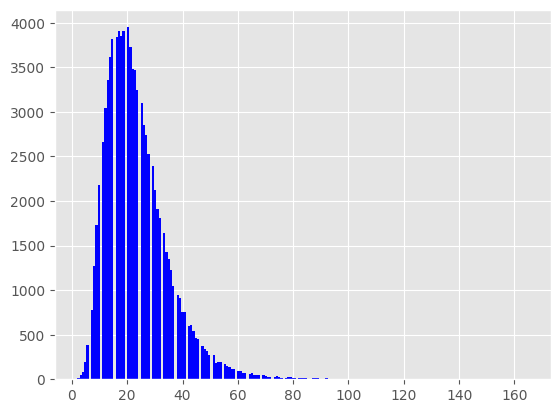

In [6]:
# Note: this code was taken from Andrea's tutorial on NER.
# This plot shows the distribution of the sentence lenghts for our data.
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.hist(len_sentences, color = 'b', bins=200)
plt.show()


In [8]:
# Interpreting the distribution for the sentence lenghts, we can determine a maximum length of 65 for padding/truncating.
max_pad = 65

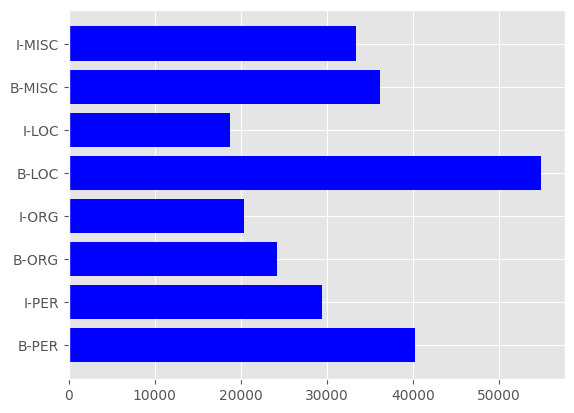

In [8]:
# Distributions of labels.
import numpy as np

# This dictionary stores the number of each NER-tag and assigns a count of zero for all values. Since the number of non-
# entities will obviously have the highest count, we will leave this out. Also, it does not give us any valuable 
# information about the distribution of the labels.
label_count = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}

# We select each list in our data["ner_tags"] column that consists of all the ner_tags for a given sentence.
for labels in data["ner_tags"]:
    # We then loop thorugh the list and select each NER-tag.
    for label in labels:
        # If the label is in our dictionary, we increase its count. We use this if-statement because we do not want to 
        # count the non-entities.
        if label in label_count:
            label_count[label] += 1

# Finally, we plot a simple horizontal barchart using matplotlib.
x = np.array([label_count[i] for i in range(1, len(label_count) + 1)])
y = np.array(['B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'])

plt.barh(y, x, color='b')
plt.show()

From the plot we can infer that our dataset seems to be skewed. The number for each NER-tag is not balanced in our dataset. We will have to take this into account when interpreting our model. Additionally, in this plot we did not include tokens that are non-entities, this will be also important for our model interpretation at the end.

                                        PREPARING THE DATA FOR THE MODEL:
In this step, the goal is to convert the data into a format a neural network can "understand". This means, we have to represent the text data as numbers. Here, we will first use the built-in Keras Tokenizer which basically gives each token in our data an unique index. We can specify how many words the tokenizer should consider. Words that are not in the vocabulary will be tagged with the OOV token, i.e. "out of vocabulary." We will convert the data into sequences and then perform padding. Padding is needed because we need to have a fixed length for our input. The max_len we have specified in the previous step, defines how long each input should be. If a sequence is shorter then max_len, we will add 0 (zeros) to fill the remaining empty spots. If a sequence is longer then max_len, we will have to reduce its length to fit the input length (this is called truncating).

In [9]:
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# First, we define how many words the tokenizer should consider - we will use 15000 as our maximum of words.
max_words = 15000

# Then we initiate the Tokenizer with the number of words and the <OOV> token.
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data["tokens"])

# We store the indexes for the words in a variable.
word_index = tokenizer.word_index

# We convert the text into sequences. Based on the the output of the tokenizer, each sentence will be now represented as a
# a sequence of integers. Here, we will use the built-in texts_to_sequences() function from Keras.
sequences = tokenizer.texts_to_sequences(data["tokens"])

# Finally, we will perform padding on the sequences of integers, with Keras' pad_sequences().
padded_sequences = pad_sequences(sequences, maxlen=max_pad, padding='post', truncating='post')

2024-08-15 11:07:03.502538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# This dictionary holds the corresponding number as a value for each NER-tag.
index_ner_tags = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
num_ner_tags = len(index_ner_tags)
print(index_ner_tags)
print(f"There are {num_ner_tags} unique NER-tags in the corpus")

{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
There are 9 unique NER-tags in the corpus


In [21]:
# After having padded the sentences, we will now do the same procedure for the NER-tags.
padded_ner_tags = pad_sequences(data["ner_tags"], maxlen=max_pad, padding='post', truncating='post')

In [18]:
padded_ner_tags[0], padded_sequences[0]

(array([0, 0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 array([   32,   765,    31,   886,     2,     1,  5074,     3,   146,
           10,     2,   543, 11771,     4,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], dtype=int32))

In [19]:
padded_ner_tags.shape, padded_sequences.shape

((92720, 65), (92720, 65))

In [24]:
# We will now transform our labels to categorical because we are dealing with a multi-classification task.
from tensorflow.keras.utils import to_categorical

# Note: this line of code was taken from Andrea's NER tutorial.
# to_categorical uses one-hot encoding to identify which NER-tag we refer to. To briefly explain, each token in our
# list of NER-tags will be now represented as a one-hot encoded list. That means, each index of this list represents
# one named entity tag. The index for the corresponding named entity tag will have a 1, all other indexes are zeros. 
padded_ner_tags = [to_categorical(i, num_classes=num_ner_tags) for i in padded_ner_tags]

In [21]:
padded_ner_tags[0]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1.

Finally, we will have to transform our list that holds all POS-tags for each sentences into a numerical representation. To achieve this, we will proceed as follows: (1) we loop through the list and extract all unique POS-tags in our dataset, (2) we create a dictionary where each tag is assigned a unique index, (3) we loop through each list with the POS-tags and substitute the string tag with its corresponding index.

In [15]:
# Note: This code is based on code from Chollet's book (see p. 182)
# Tis function will return the unique POS-tags.
def extract_unique_pos_tags(data):
    unique_tags = {}
    
    # We select each list with POS-tags corresponding to each sentence.
    for sent in data:
        # We select each tag in the list.
        for tag in sent:
            # If the tag is not in our uniq_tags dictionary, we will create a new key with the POS-tag and assign it a
            # unique index as values (we simply take the lenght of the dictionary and add 1).
            if tag not in unique_tags:
                unique_tags[tag] = len(unique_tags) + 1
    
    return unique_tags


pos_tags_index = extract_unique_pos_tags(tags_data)

In [31]:
print(pos_tags_index)
num_unique_pos = len(pos_tags_index)

print(f"There are {num_unique_pos} unique POS-tags.")

{'DT': 1, 'NN': 2, 'RB': 3, 'VBZ': 4, 'NNP': 5, ',': 6, 'TO': 7, '.': 8, 'NNS': 9, 'VB': 10, ':': 11, 'PRP': 12, 'WDT': 13, 'JJ': 14, 'IN': 15, 'CC': 16, 'VBN': 17, 'VBP': 18, 'CD': 19, 'RBR': 20, 'VBD': 21, 'PRP$': 22, 'VBG': 23, 'MD': 24, 'RP': 25, 'RBS': 26, '(': 27, ')': 28, 'NNPS': 29, 'JJS': 30, 'JJR': 31, 'FW': 32, 'WRB': 33, 'WP': 34, 'PDT': 35, '#': 36, '$': 37, 'EX': 38, 'WP$': 39, 'SYM': 40, 'POS': 41, 'LS': 42, "''": 43, 'UH': 44, '``': 45}
There are 45 unique POS-tags.


In [16]:
# In this step we substitute the POS-tags with their corresponding indexes from the dictionary.
pos_tags_numeric = []

# We select each list of tags.
for sent in tags_data:
    # We create a temporary list to append to pos_tags_numeric.
    temp_nums = []
    # We select each POS-tag in the list and use it as a key for the pos_tags_index dictionary and append the value
    # (i.e. its unique index) to the temporary list.
    for tag in sent:
        temp_nums.append(pos_tags_index[tag])
    # Finally, we append the temporary list to pos_tags_numeric.
    pos_tags_numeric.append(temp_nums)

In [25]:
# To illustrate, we will look at the POS-tags for the first sentence and its corresponding unique indexes. Also, we
# will print the look-up dictionary to make sure we assigned the correct index.
for tag, num in zip(tags_data[0], pos_tags_numeric[0]):
    print(f"{tag} ------> {num}")
print(pos_tags_index)

DT ------> 1
NN ------> 2
RB ------> 3
VBZ ------> 4
DT ------> 1
NNP ------> 5
NNP ------> 5
, ------> 6
NN ------> 2
TO ------> 7
DT ------> 1
NNP ------> 5
NN ------> 2
. ------> 8
{'DT': 1, 'NN': 2, 'RB': 3, 'VBZ': 4, 'NNP': 5, ',': 6, 'TO': 7, '.': 8, 'NNS': 9, 'VB': 10, ':': 11, 'PRP': 12, 'WDT': 13, 'JJ': 14, 'IN': 15, 'CC': 16, 'VBN': 17, 'VBP': 18, 'CD': 19, 'RBR': 20, 'VBD': 21, 'PRP$': 22, 'VBG': 23, 'MD': 24, 'RP': 25, 'RBS': 26, '(': 27, ')': 28, 'NNPS': 29, 'JJS': 30, 'JJR': 31, 'FW': 32, 'WRB': 33, 'WP': 34, 'PDT': 35, '#': 36, '$': 37, 'EX': 38, 'WP$': 39, 'SYM': 40, 'POS': 41, 'LS': 42, "''": 43, 'UH': 44, '``': 45}


In [26]:
# The sequences of the POS-tags have to be padded as well.
padded_pos_tags = pad_sequences(pos_tags_numeric, maxlen=max_pad, padding='post', truncating='post')

In [27]:
padded_pos_tags[0]

array([1, 2, 3, 4, 1, 5, 5, 6, 2, 7, 1, 5, 2, 8, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [27]:
# Before we compile our first model, we want to split our data in training and testing sets. We will use sklearn's
# train_test_split function. First, we will split the sentences and its corresponding labels. Then, we also split our 
# sequences of POS-tags that we need for the first model.
from sklearn.model_selection import train_test_split

# x_train and y_train will consist of the sentences and y_train and y_test will consist of the corresponding labels.
# The size of the test set will be 0.1 (10%) of the dataset.
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, padded_ner_tags, test_size=0.1)

# We will use the same function for the POS-tags. However, since we do not need any labels and only want to split the
# sequences in the same sizes as for x_train, x_test, etc., we will use "_, _". The function expects to return four 
# sets, but we only want two (i.e. the split sets for the POS-tags). Also, by using the same function as above, we 
# ensure that we have the exact same split. Otherwise, the sequences of POS-tags might not be matching with the 
# sequences of sentences and their named entity tags.
train_pos, test_pos, _, _ = train_test_split(padded_pos_tags, padded_ner_tags, test_size=0.1)

In [29]:
# Here, we are making sure that we have the same size for the splits.
print(f"Shape train: {x_train.shape}\nShape test: {x_test.shape}\nShape pos_train: {train_pos.shape}\nShape pos_test: {test_pos.shape}")

Shape train: (83448, 65)
Shape test: (9272, 65)
Shape pos_train: (83448, 65)
Shape pos_test: (9272, 65)


                                                        MODEL 1:
For the first model, we will use POS-tags as features. That means that besides the text input, the sentences, we will have a second input, namely the 
corresponding POS-tags for each sentence. To build such a model, we will first define two embedding layers, one for the sentences and the other for the POS-tags. Then, we will use keras' layers.concatenate() function to combine both embedding layers. Lastly, we will compile our model and proceed to the training
phase. 

NOTE: The code for this model, specifically the code for multi-input models, is based on the Chollet book (pp. 238-39).

In [29]:
# First we will load all the necessary built-in functions from keras.
from keras.models import Model, Sequential
from keras import layers
from keras import Input

In [32]:
# We will start with the embedding layer for our text input.

# First we define the input size which is defined in the max_pad variable (65).
text_input = Input(shape=(max_pad,), name='text_input')

# We will now define the embedding layer for the text input. The input dimesnion is the size of our vocabulary (15000), the input lenght is the length for
# padding (65), and we define the output dimensions as 64. This function will embed the inputs into a sequence of vectors with the size of 64.
embedded_text = layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_pad)(text_input)

# Finally we will encode the vectors into a single vector with a LSTM.
encoded_text = layers.LSTM(32, return_sequences=True)(embedded_text)

# We will now perform the same process for the embedding POS-tags, but with different instances for the layers.
pos_input = Input(shape=(max_pad,), name='pos_input')

# The embedding layer with an output dimension of 32. The input dimension is the numebr of unique POS-tags.
embedded_pos = layers.Embedding(input_dim=num_unique_pos, output_dim=32, input_length=max_pad)(pos_input)

# Finally, the LSTM layer.
encoded_pos = layers.LSTM(16, return_sequences=True)(embedded_pos)

# Now, we will concatenate both layers.
concatenated = layers.concatenate([encoded_text, encoded_pos])

# In the final step, we will define an output layer for the model. Here, we will use a dense layer with the amount of named entity tags as output. Meaning
# the model will output a probability score for each named entity label for a specific input. For the probability score, we will use softmax. Softmax computes
# a probability score for each possible output; the sum of all scores for each output will be 1. The label with the highest probability score, will be the
# tag that the model outputs. This output layer will be added "on top" of the concatenated layer.
answer = layers.Dense(num_ner_tags, activation='softmax')(concatenated)

In [32]:
# We will now compile the model. It will have two inputs and the corresponding input sizes we defined above as well as the softmax output layer.
model1 = Model([text_input, pos_input], answer)

model1.summary()

# We will use the "rmsprop" as optimizer bacause it was also used in other notebooks for the same task (we will, however, experiment with the optimizer in the
# other models). Since we have more than two labels, we use "categorical_crossentropy" as the loss function. The metrics will be accuracy.
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 65)]         0           []                               
                                                                                                  
 pos_input (InputLayer)         [(None, 65)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 65, 64)       960000      ['text_input[0][0]']             
                                                                                                  
 embedding_1 (Embedding)        (None, 65, 32)       1440        ['pos_input[0][0]']              
                                                                                              

In [33]:
# Training the model. We will input both the the sentences (x_train) as well as the pos tags (train_pos), and the 
# one-hot encoded labels for the named entities (y_train) by converting it to a numpy array. The batch size will be 64 
# (that means we will use 64 samples from the training data for training the model). We will train the model over 5 
# epochs. And finally, we define the split for the validation set as 0.1 (10% of the training data).
history1 = model1.fit([x_train, train_pos], np.array(y_train), batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5


2024-08-10 14:36:57.820222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2024-08-10 14:36:57.891548: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f297c0ce910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-10 14:36:57.891596: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-08-10 14:36:57.891602: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2024-08-10 14:36:57.891605: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Quadro RTX 5000, Compute Capability 7.5
2024-08-10 14:36:57.896856: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-10 14:36:57.967842: I tensorflow/tsl/platform/default/s

1174/1174 [==============================] - 31s 23ms/step - loss: 0.1802 - accuracy: 0.9594 - val_loss: 0.1120 - val_accuracy: 0.9668
Epoch 2/5
1174/1174 [==============================] - 12s 10ms/step - loss: 0.0898 - accuracy: 0.9726 - val_loss: 0.0796 - val_accuracy: 0.9761
Epoch 3/5
1174/1174 [==============================] - 10s 9ms/step - loss: 0.0711 - accuracy: 0.9784 - val_loss: 0.0704 - val_accuracy: 0.9791
Epoch 4/5
1174/1174 [==============================] - 10s 9ms/step - loss: 0.0625 - accuracy: 0.9812 - val_loss: 0.0629 - val_accuracy: 0.9812
Epoch 5/5
1174/1174 [==============================] - 10s 8ms/step - loss: 0.0575 - accuracy: 0.9826 - val_loss: 0.0604 - val_accuracy: 0.9818


In [36]:
# Now we are going to evaluate the model's performance on the test data. In this step, we can see how the model performs on data that it has not yet seen
# before. In other words, how good is the model at transferring its knwoledge? x_test are the test sentences, pos_test are the corresponding POS-tags, and
# y_test (again transferred to a numpy array) are the named entity labels.
model1.evaluate([x_test, test_pos], np.array(y_test))

290/290 [==============================] - 2s 5ms/step - loss: 0.0597 - accuracy: 0.9822


[0.05973879620432854, 0.9821962118148804]

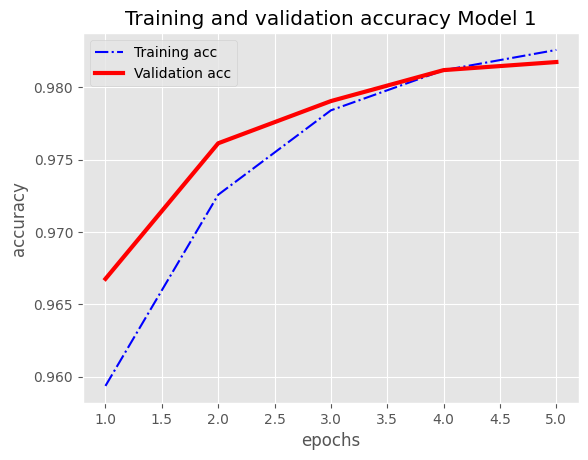

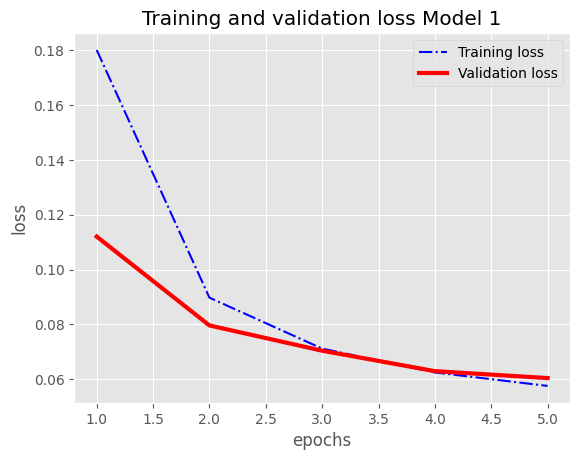

In [35]:
# Note: This code is based on the various notebooks from the course.
# We will now visualize the training and validation accurary and loss for our first model.
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

epochs1 = range(1, len(loss1) + 1) 

plt.plot(epochs1, acc1, 'b', linestyle = 'dashdot', label='Training acc')
plt.plot(epochs1, val_acc1, 'r', linewidth = '3', label='Validation acc')
plt.title('Training and validation accuracy Model 1')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.figure()

plt.plot(epochs1, loss1, 'b', linestyle = 'dashdot', label='Training loss')
plt.plot(epochs1, val_loss1, 'r', linewidth = '3', label='Validation loss')
plt.title('Training and validation loss Model 1')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.show()

                                                    MODEL 2:
For our second model, we will use pre-trained, static word embeddings. Pre-trained means that for a set of vocabulary, each word has been assigned a word embedding. There are several algorithms for creating word embeddings, e.g., word2vec, GloVe etc. Although all these algorithms have a different approach of creating word embeddings, they have one thing in common: they are static word embeddings, in contrast to contextual word embeddings (more about contextual embeddings in the third model). Static word embeddings have a fixed embedding for each word in the vocabulary. In other words, the embeddings do not change. For our model, we will use the pre-trained word embeddings from GloVe, which can be downloaded here: https://nlp.stanford.edu/projects/glove/. From the GloVe word embeddings, we will use the embeddings with a dimension of 100. 

Note: The code for loading the embeddings and preparing a word-embeddings matrix, is taken from the Chollet book (pp. 190-91)

In [43]:
# The first step is to load the word embeddings in this notebook. When we have loaded the embeddings, we will
# parse through the text file and map each word to its vector representation. We perform this 
# step because GloVe provides us with a text file and we have to extract all words and their vector representations 
# and convert them into a look-up dictionary (key = word, value = vector representation).

# This dictionary will hold the words and their vector representations.
embeddings_index = {}

# We open the GloVe file.
f = open('glove.6B.100d.txt')

# We iterate through each line in the file.
for line in f:
    # We tokenize the line by whitespace. We now have a list that looks like this ["word", "float1", "float2", ...].
    values = line.split()
    # We can now extract the first element, i.e., the word...
    word = values[0]
    # And also the remaining elements from the list, i.e., the floating numbers that make up the vector representation.
    coefs = np.asarray(values[1:], dtype='float32')
    # Finally we create an dictionary entry with word as key and vector as value.
    embeddings_index[word] = coefs

f.close()

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [44]:
# In the second step, we will build an embedding matrix. This embedding matrix will be loaded later into an embedding
# layer of our model. The idea is to extract the pre-trained vector representations for each word in our vocabulary 
# (as long as its index is smaller than the maximum size of our vocabulary).

# We set the mebdding dimension to 100.
embedding_dim = 100

# We create the mebdding matrix of the size of our vocabulary x the embedding dimension. We fill the matrix at the
# beginning only with zeros.
embedding_matrix = np.zeros((max_words, embedding_dim))

# We iterate through the words and indexes in our vocabulary.
for word, i in word_index.items():
    # We make sure the index is not greater than our vocabulary size.
    if i < max_words:
        # We extract the pre-trained vector representation for the selected word.
        embedding_vector = embeddings_index.get(word)
        # Before we add the vector to the embedding matrix, we make sure that the word existed in the pre-trained
        # word embeddings.
        if embedding_vector is not None:
            # We add the index and the vector representation to our embedding matrix.
            embedding_matrix[i] = embedding_vector

In [45]:
# We will now configure our second model that uses our pre-trained word embeddings and see how well it performs. This
# model will use one LSTM layer with 100 units, and a dense output layer with the number of unique named entity tags
# and againg with the "softmax" to compute a probability score for each label that sums to 1.

# We are using a sequential model.
model2 = Sequential()

# We add an embedding layer with max_words (the number of words in our vocabulary), embedding_dim (embedding dimensions
# of 100), and max_pad (the input length of 65).
model2.add(layers.Embedding(max_words, embedding_dim, input_length=max_pad))

# Now we add the LSTM layer with 100 units that will return the sequences.
model2.add(layers.LSTM(100, return_sequences=True))

# Now we add a Dense output layer with the number of output labels and softmax.
model2.add(layers.Dense(num_ner_tags, activation='softmax'))

model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 65, 100)           1500000   
                                                                 
 lstm_15 (LSTM)              (None, 65, 100)           80400     
                                                                 
 dense_14 (Dense)            (None, 65, 9)             909       
                                                                 
Total params: 1,581,309
Trainable params: 1,581,309
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Before we train the model on the data, we load the GloVe embeddings into our model.
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

In [56]:
# Now we compile the model. This time, we will experiment a bit with the optimizer and use "ADAM" instead of "rmsprop".
model2.compile(optimizer='ADAM', loss='categorical_crossentropy', metrics=['accuracy'])

# Finally, we fit the training data and the labels to the model. We change the batch size from 64 to 32 and will train over 3 instead of 5 epochs.
history2 = model2.fit(x_train, np.array(y_train), batch_size=32, epochs=3, validation_split=0.1)

Epoch 1/3


2024-08-14 13:04:39.703021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2024-08-14 13:04:39.760788: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55eaea053ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-14 13:04:39.760843: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-08-14 13:04:39.760853: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2024-08-14 13:04:39.760860: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Quadro RTX 5000, Compute Capability 7.5
2024-08-14 13:04:39.767681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-14 13:04:39.842738: I tensorflow/tsl/platform/default/s

2347/2347 [==============================] - 18s 7ms/step - loss: 0.1047 - accuracy: 0.9725 - val_loss: 0.0686 - val_accuracy: 0.9795
Epoch 2/3
2347/2347 [==============================] - 16s 7ms/step - loss: 0.0635 - accuracy: 0.9809 - val_loss: 0.0597 - val_accuracy: 0.9818
Epoch 3/3
2347/2347 [==============================] - 16s 7ms/step - loss: 0.0568 - accuracy: 0.9827 - val_loss: 0.0550 - val_accuracy: 0.9830


In [57]:
# We will also evaluate this model on our test data.
model2.evaluate(x_test, np.array(y_test))

290/290 [==============================] - 1s 4ms/step - loss: 0.0566 - accuracy: 0.9825


[0.056595586240291595, 0.9825496077537537]

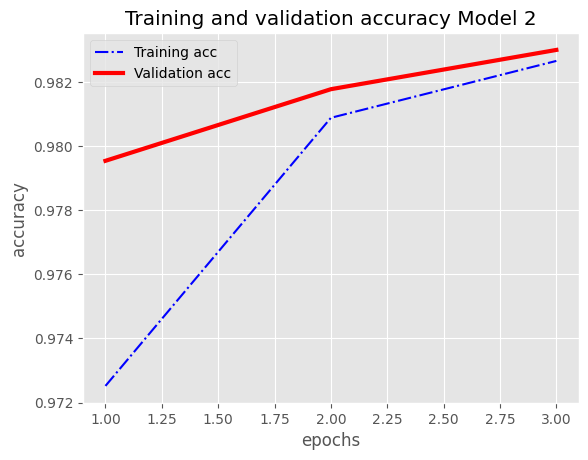

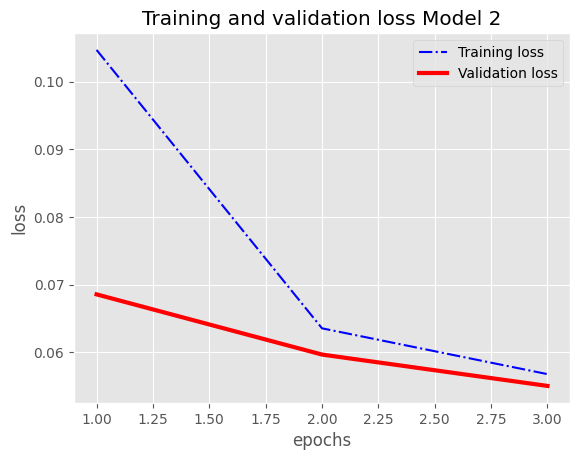

In [58]:
# Note: This code is based on the various notebooks from the course.
# We will now visualize the training and validation accurary and loss for our first model.
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

epochs2 = range(1, len(loss2) + 1) 

plt.plot(epochs2, acc2, 'b', linestyle = 'dashdot', label='Training acc')
plt.plot(epochs2, val_acc2, 'r', linewidth = '3', label='Validation acc')
plt.title('Training and validation accuracy Model 2')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.figure()

plt.plot(epochs2, loss2, 'b', linestyle = 'dashdot', label='Training loss')
plt.plot(epochs2, val_loss2, 'r', linewidth = '3', label='Validation loss')
plt.title('Training and validation loss Model 2')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.show()

                                                        DISCUSSING THE FIRST AND THE SECOND MODEL:
In this section we will look at the first and second model and compare their results. How did they perform? Did we achieve any significant differences by changing the parameters of the model? What might be some potential errors the model did? How could we fix them?

In [62]:
# To begin with, we will create a dataframe to illustrate the different parameters of the model.
models_parameters = {"MODEL 1": ["POS-tags", "LSTM, units=64", "LSTM, units=32", "rmsprop", "64", "5", "0.0575", "0.9826 (98,26%)", "0.0604", "0.9818 (98,18%)", "0.0597", "0.9822 (98,22%)"],
                     "MODEL 2": ["Static embeddings", "LSTM, units=100", "-", "ADAM", "32", "3", "0.0568", "0.9827 (98,27%)", "0.0550", "0.9830 (98,30%)", "0.0566", "0.9825 (98,25%)"] }

rows = ["Features", "Layer 1", "Layer 2", "Optimizer", "Batch size", "Epochs", "Train loss", "Train acc", "Val loss", "Val acc", "Test loss", "Test acc"]

df_models = pd.DataFrame(models_parameters, index=rows)

df_models

,MODEL 1,MODEL 2
Features,POS-tags,Static embeddings
Layer 1,"LSTM, units=64","LSTM, units=100"
Layer 2,"LSTM, units=32",-
Optimizer,rmsprop,ADAM
Batch size,64,32
Epochs,5,3
Train loss,0.0575,0.0568
Train acc,"0.9826 (98,26%)","0.9827 (98,27%)"
Val loss,0.0604,0.0550
Val acc,"0.9818 (98,18%)","0.9830 (98,30%)"


                                                                FINAL THOUGHTS:
In this notebook, we used a dataset to train three different models for Named Entity Recognition. We had to perform various pre-processing task to convert our dataset into an appropriate format to input it to our models. We compiled three different models: (1) multi-input with POS-tags and (2) static word embeddings. We have seen that both models perform very well. This performance, however, has to be taken with a grain of salt. First, our dataset we used for the model was skewed, the label classes wer imbalanced. Second, in the task of NER the most common label is non-entity which means when we train a model on predicting a NER-tag, we have to take this into account. Especially when we only look at the accuracy metrics we might get misleading results. A better way of approaching this is to also include F1 score in the evaluation of the model. 

In conclusion, working on this project was a great opportunity to experiment with keras and neural networks. I was able to learn a lot and put the theory to practice. 